In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
from matplotlib import axes
import os 
import pandas as pd
import json

import sys, os
sys.path.append('/cluster/home/kamara/Explain')
from clutils.nbutils import *
from clutils.nbutils.params import get_param_ranges
os.getcwd()
from os.path import join
sns.set()

In [16]:
palette = sns.color_palette("Paired", 25)

In [10]:
def get_info(logdir):
    logs = {}
    train_scores, test_scores = {}, {}
    for filename in os.listdir(logdir):
        if filename.endswith(".stdout") and filename.startswith("_"):
            _, logs[filename.replace(".stdout", "")] = parseLogs(join(logdir, filename), kw='__logs')
            _, train_scores[filename.replace(".stdout", "")] = parseLogs(join(logdir, filename), kw='__gnn_train_scores')
            _, test_scores[filename.replace(".stdout", "")] = parseLogs(join(logdir, filename), kw='__gnn_test_scores')
    return(logs, train_scores, test_scores)

def get_df_results(logs, ranges, name, metrics, selection = 'last'):
    dicts = []
    for params_set in enumerateParams(ranges):
        key = name.format(**params_set)
        # if key in logs and len(logs[key]) >= 1 and metric in logs[key]:
        any_metric = (key in logs) and (len(logs[key]) >= 1) and any([metric in logs[key] for metric in metrics])
        if any_metric:
            if selection == 'all':
                for index, row in logs[key].iterrows():
                    metrics_dict = {
                        metric: select_value(row.to_frame().T, metric, 'last') if key in logs and len(logs[key]) >= 1 and metric in logs[key] else -1
                        for metric in metrics
                    }
                    dicts.append(dictmerge(params_set, metrics_dict))
                    
            else:
                metrics_dict = {
                    metric: select_value(logs[key], metric, selection) if key in logs and len(logs[key]) >= 1 and metric in logs[key] else -1
                    for metric in metrics
                }
                dicts.append(dictmerge(params_set, metrics_dict))

    df = pd.DataFrame(dicts)
    return df

# Gridsearch GNN for FacebookPagePage

In [17]:
logdir = f'/cluster/home/kamara/Explain/checkpoints/node_classification/facebook/gridsearch_facebook_lr/logs'
jsonpath = f'/cluster/home/kamara/Explain/checkpoints/node_classification/facebook/gridsearch_facebook_lr/sweep.json'
logs, train_scores, test_scores = get_info(logdir)

print(list(logs.keys())[1])
name = '{none}_lr={lr}'

ranges = get_param_ranges(jsonpath)

Unable to replace NaNs
__gnn_train_scores: {"prec": 0.6374827385328954, "recall": 0.6300875829268844, "acc": 0.7410650887573964}

Unable to replace NaNs
__gnn_test_scores: {"prec": 0.6562919274012158, "recall": 0.6439847812887728, "acc": 0.7486033519553073}

Unable to replace NaNs
__gnn_train_scores: {"prec": 0.5825234743589316, "recall": 0.5530786195495566, "acc": 0.5983870967741935}

Unable to replace NaNs
__gnn_test_scores: {"prec": 0.5377300857715505, "recall": 0.5159180474697717, "acc": 0.5791190864600326}

Unable to replace NaNs
__gnn_train_scores: {"prec": 0.4369738061025581, "recall": 0.4297099571090872, "acc": 0.4847926267281106}

Unable to replace NaNs
__gnn_test_scores: {"prec": 0.44449575286965004, "recall": 0.42937742573518434, "acc": 0.4893964110929853}

Unable to replace NaNs
__gnn_train_scores: {"prec": 0.558714161385762, "recall": 0.5297375735671391, "acc": 0.6610650887573964}

Unable to replace NaNs
__gnn_test_scores: {"prec": 0.5634778483065651, "recall": 0.541462243

In [18]:
logs

{'_lr=0.003':     val_err  train_err
 0    0.0205     5.0516
 1    0.0042     1.0532
 2    0.0032     0.8906
 3    0.0020     0.8688
 4    0.0013     0.7408
 ..      ...        ...
 95   0.0022     0.7298
 96   0.0016     0.6816
 97   0.0023     0.7049
 98   0.0031     0.8216
 99   0.0027     0.9037
 
 [100 rows x 2 columns],
 '_lr=0.001':     val_err  train_err
 0    0.0168     9.0838
 1    0.0057     1.8422
 2    0.0068     1.3273
 3    0.0046     1.0129
 4    0.0043     0.9558
 ..      ...        ...
 95   0.0035     0.9190
 96   0.0038     0.8801
 97   0.0040     0.8085
 98   0.0032     0.7829
 99   0.0028     0.9054
 
 [100 rows x 2 columns],
 '_lr=0.1':     val_err  train_err
 0    0.0203    11.0104
 1    0.0216     6.7433
 2    0.0277    14.7462
 3    0.0210     5.9642
 4    0.0113     3.4498
 ..      ...        ...
 95   0.1360    18.5274
 96   0.0106     3.9283
 97   0.0115     5.3153
 98   0.0214     9.2834
 99   0.0158     4.1578
 
 [100 rows x 2 columns],
 '_lr=0.005':     

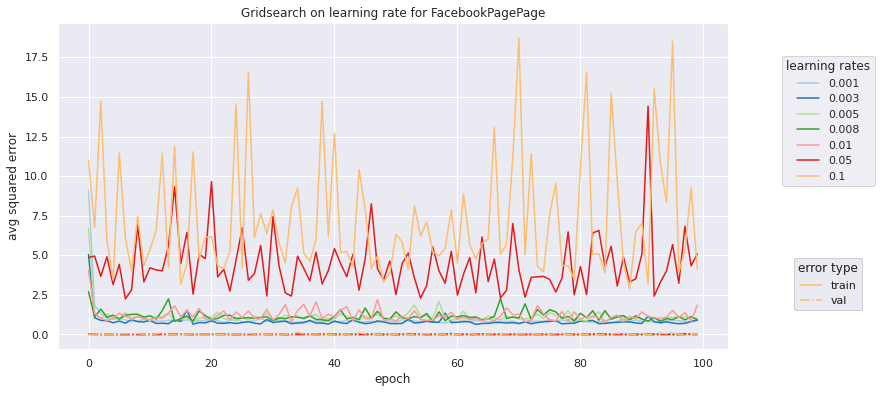

In [19]:
fig, ax = plt.subplots(1, figsize = (12,6), sharex=True, sharey=True)
plt.rcParams['axes.grid'] = True
plot_lines = []
for params_set in enumerateParams(ranges):
    key = name.format(**params_set)
    v = logs[key]
    if v.empty == False:
        val_losses = v["val_err"]
        train_losses = v["train_err"]
        nepochs = len(val_losses)*10
        lr = params_set['lr']
        i = ranges['lr'].index(lr)
        
        l1, = ax.plot(train_losses, label=lr, c = palette[i])
        l2, = ax.plot(val_losses, c = palette[i], ls ='dashdot')
        plot_lines += [l1]
        
# set labels
plt.setp(ax, xlabel="epoch")
plt.setp(ax, ylabel="avg squared error")

ax.set_title("Gridsearch on learning rate for FacebookPagePage")

legend1 = plt.legend(plot_lines, ranges['lr'], bbox_to_anchor=(1.15, 0.7), loc = 'center', title='learning rates')
plt.gca().add_artist(legend1)

legend2 = plt.legend([l1, l2], ['train', 'val'], title='error type', bbox_to_anchor=(1.15, 0.2), loc = 'center')
plt.gca().add_artist(legend2)

plt.grid(True)
#plt.tight_layout()
plt.show()

# Gridsearch GNN for Cora, CiteSeer and PubMed

In [ ]:
logdir = f'/cluster/home/kamara/Explain/checkpoints/node_classification/planetoid/test/logs'
jsonpath = f'/cluster/home/kamara/Explain/checkpoints/node_classification/planetoid/test/sweep.json'
logs, train_scores, test_scores = get_info(logdir)

print(list(logs.keys())[1])
name = '{none}_explainer_name={explainer_name}_sparsity={sparsity}_dataset={dataset}_hard_mask={hard_mask}'

ranges_all = get_param_ranges(jsonpath)

## Learning rate

In [ ]:
# Fix weight decay, dropout
df = logs[(logs.weight_decay==0.0)&(logs.dropout==0.0)]
ranges = ranges_all.copy()
ranges['weight_decay'] == 0
ranges['dropout'] = 0

In [ ]:
palette = sns.color_palette("Paired", 25)

fig, axs = plt.subplots(2, 2, figsize = (12,6), sharex=True, sharey=True)
plt.rcParams['axes.grid'] = True
plot_lines = []
for params_set in enumerateParams(ranges):
    key = name.format(**params_set)
    v = logs[key]
    if v.empty == False:
        val_losses = v["val_err"]
        train_losses = v["train_err"]
        nepochs = len(val_losses)*10
        dataset = params_set['dataset']
        lr = params_set['lr']
        i = ranges['lr'].index(lr)

        if dataset=='Cora':
            l1, = axs[0,0].plot(train_losses, label=lr, c = palette[i])
            l2, = axs[0,0].plot(val_losses, c = palette[i], ls ='dashdot')

        elif optimizer=='CiteSeer':
            l1, = axs[0,1].plot(train_losses, label=lr, c = palette[i])
            l2, = axs[0,1].plot(val_losses, c = palette[i], ls ='dashdot')

        elif optimizer=='PubMed':
            l1, = axs[1,0].plot(train_losses, label=lr, c = palette[i])
            l2, = axs[1,0].plot(val_losses, c = palette[i], ls ='dashdot')

        else:
            print('Not an neural net')


axs[0,0].set_title(f"Cora")
axs[0,1].set_title(f"CiteSeer")
axs[1,0].set_title(f"PubMed")

# set labels
plt.setp(axs, xlabel="epoch")
plt.setp(axs, ylabel="avg squared error")

legend1 = plt.legend(plot_lines, ranges['lr'], bbox_to_anchor=(1.15, 1.45), loc = 'center', title='learning rate')
plt.gca().add_artist(legend1)

legend2 = plt.legend([l1, l2], ['train', 'val'], title='error type', bbox_to_anchor=(1.15, 0.2), loc = 'center')
plt.gca().add_artist(legend2)

fig.suptitle('Gridsearch on learning rate', fontsize=16)
plt.grid(True)
#plt.tight_layout()
plt.show()